In [165]:
# Import necessary libraries
import pyspark
import nltk
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, explode , count , when
from pyspark.sql.types import StringType, ArrayType
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import os
from nltk import ngrams



In [166]:
# Initialize Spark session
findspark.init("C:/Users/AYUSHI/Downloads/spark-3.5.3")

spark = SparkSession.builder \
    .master("local[4]")\
    .appName("Text Preprocessing with Ngrams") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()


In [167]:
# Set up NLTK data path
nltk_data_path = 'C:/Users/AYUSHI/nltk_data'
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

nltk.data.path.append(nltk_data_path)
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt', download_dir=nltk_data_path)
    nltk.download('stopwords', download_dir=nltk_data_path)


In [168]:
import os
print(os.listdir('C:/Users/AYUSHI/nltk_data/tokenizers'))


['punkt', 'punkt.zip']


In [169]:
tokenizer = TreebankWordTokenizer()


In [170]:
# Broadcasting stopwords and lemmatizer
stop_words_bc = spark.sparkContext.broadcast(set(stopwords.words('english')))
lemmatizer_bc = spark.sparkContext.broadcast(WordNetLemmatizer())



In [171]:
# Define preprocessing function
def preprocess_text(text):
    if text is None or not isinstance(text, str):
        return ""
    text = re.sub(r'[\\/|,]', ' ', text)  # Replace slashes and commas
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)
    text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove non-alphabetic characters

    # Tokenize, lowercase, and lemmatize
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text.lower())
    tokens = [lemmatizer_bc.value.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words_bc.value]
    return ' '.join(tokens)

# Register UDF for preprocessing
preprocess_udf = udf(preprocess_text, StringType())

# Load dataset
file_path = r"C:/BDA proj/cleaned_datasets/combined_data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Preprocess relevant columns
df = df.fillna("", subset=["skills", "locations", "industry", "roles"])
df = df.withColumn("cleaned_skills", preprocess_udf(col("skills"))) \
       .withColumn("processed_location", preprocess_udf(col("locations"))) \
       .withColumn("processed_industry", preprocess_udf(col("industry"))) \
       .withColumn("processed_roles", preprocess_udf(col("roles")))

In [172]:
df.printSchema()


root
 |-- roles: string (nullable = false)
 |-- companies: string (nullable = true)
 |-- locations: string (nullable = false)
 |-- experience: string (nullable = true)
 |-- skills: string (nullable = false)
 |-- salary: string (nullable = true)
 |-- industry: string (nullable = false)
 |-- experience_cleaned: string (nullable = true)
 |-- min_experience: string (nullable = true)
 |-- max_experience: string (nullable = true)
 |-- min_salary: double (nullable = true)
 |-- max_salary: double (nullable = true)
 |-- is_salary_disclosed: string (nullable = true)
 |-- avg_salary: string (nullable = true)
 |-- days_ago: string (nullable = true)
 |-- posting_date: string (nullable = true)
 |-- job_age_days: string (nullable = true)
 |-- seniority_level: string (nullable = true)
 |-- is_remote: string (nullable = true)
 |-- is_high_salary: string (nullable = true)
 |-- cleaned_skills: string (nullable = true)
 |-- processed_location: string (nullable = true)
 |-- processed_industry: string (null

In [173]:
# Filter out rows with empty or null values in key columns
columns_to_check = ["days_ago", "posting_date", "job_age_days", "processed_location", "processed_roles"]
cleaned_df = df.filter(~(
    (col("days_ago").isNull() | (col("days_ago") == "")) |
    (col("posting_date").isNull() | (col("posting_date") == "")) |
    (col("job_age_days").isNull() | (col("job_age_days") == "")) |
    (col("processed_location").isNull() | (col("processed_location") == "")) |
    (col("processed_roles").isNull() | (col("processed_roles") == ""))
))

# Show the size of the cleaned DataFrame
cleaned_size = cleaned_df.count()
print(f"Size of the cleaned DataFrame: {cleaned_size} rows")

# Display a few rows of the cleaned DataFrame
cleaned_df.show(5, truncate=False)


Size of the cleaned DataFrame: 263250 rows
+---------------------------------------------+------------------+---------+----------+---------------------------------------------------------------------------------------------------------------------------------------------+-------------+--------+------------------+--------------+--------------+----------+----------+-------------------+----------+--------+------------+------------+---------------+---------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------+------------------+------------------+--------------------------------------+
|roles                                        |companies         |locations|experience|skills                                                                                                                                       |salary       |industry|experience_cleaned|min_experience|max_experience

In [174]:
def extract_ngrams_debug(text, n):
    if not text or len(text.split()) < n:
        print(f"Skipping text: {text}")
        return []
    tokens = text.split()
    ngrams_list = [' '.join(ngram) for ngram in ngrams(tokens, n)]
    print(f"Extracted {n}-grams: {ngrams_list}")
    return ngrams_list


In [175]:
# Split the dataframe into multiple partitions (using repartition)
num_partitions = 10  # Adjust the number of partitions according to your system's memory
cleaned_df_partitioned = cleaned_df.repartition(num_partitions)

# Function to extract n-grams
def extract_ngrams(text, n):
    if not text or len(text.split()) < n:
        return []
    tokens = text.split()  # Tokenizing by space (can be adjusted to use word_tokenize)
    return [' '.join(ngram) for ngram in ngrams(tokens, n)]

# Define UDFs for bigrams and trigrams
extract_bigrams_udf = udf(lambda text: extract_ngrams(text, 2), ArrayType(StringType()))
extract_trigrams_udf = udf(lambda text: extract_ngrams(text, 3), ArrayType(StringType()))

# Step 1: Tokenize the 'skills' column (or other relevant column) to create tokens
cleaned_df_partitioned = cleaned_df_partitioned.withColumn("tokens", extract_bigrams_udf(col("cleaned_skills")))

# Step 2: Generate Bigrams and Trigrams using the UDFs
cleaned_df_partitioned = cleaned_df_partitioned.withColumn("bigrams", extract_bigrams_udf(col("cleaned_skills")))
cleaned_df_partitioned = cleaned_df_partitioned.withColumn("trigrams", extract_trigrams_udf(col("cleaned_skills")))

# Step 3: Explode n-grams into rows
try:
    bigrams_exploded = cleaned_df_partitioned.select(explode(col("bigrams")).alias("bigram"))
    trigrams_exploded = cleaned_df_partitioned.select(explode(col("trigrams")).alias("trigram"))
except Exception as e:
    print(f"Error during explode: {e}")
    raise

# Step 4: Count n-gram frequencies
bigram_counts = bigrams_exploded.groupBy("bigram").count().orderBy(col("count").desc())
trigram_counts = trigrams_exploded.groupBy("trigram").count().orderBy(col("count").desc())

# Step 5: Apply threshold filtering and display the results
try:
    BIGRAM_THRESHOLD = 50
    TRIGRAM_THRESHOLD = 30

    # Filter bigrams and trigrams based on the threshold
    filtered_bigrams = bigram_counts.filter(col("count") >= BIGRAM_THRESHOLD)
    filtered_trigrams = trigram_counts.filter(col("count") >= TRIGRAM_THRESHOLD)

    # Show results
    filtered_bigrams.show(2, truncate=False)
    filtered_trigrams.show(2, truncate=False)
except Exception as e:
    print(f"Error during show: {e}")


+--------------------+-----+
|bigram              |count|
+--------------------+-----+
|business development|9505 |
|project management  |9470 |
+--------------------+-----+
only showing top 2 rows

+-------------------------+-----+
|trigram                  |count|
+-------------------------+-----+
|manager quality assurance|3255 |
|mentor trainer advisor   |2858 |
+-------------------------+-----+
only showing top 2 rows



In [176]:
# Count the frequency of each n-gram
bigram_counts = bigrams_exploded.groupBy("bigram").count().orderBy(col("count").desc())
trigram_counts = trigrams_exploded.groupBy("trigram").count().orderBy(col("count").desc())

# Define thresholds for filtering significant n-grams
BIGRAM_THRESHOLD = 50
TRIGRAM_THRESHOLD = 30

# Filter n-grams based on frequency thresholds
filtered_bigrams = bigram_counts.filter(col("count") >= BIGRAM_THRESHOLD)
filtered_trigrams = trigram_counts.filter(col("count") >= TRIGRAM_THRESHOLD)

# Add the comparison logic here to combine bigrams and trigrams
bigram_dict = {row["bigram"]: row["count"] for row in filtered_bigrams.collect()}
trigram_dict = {row["trigram"]: row["count"] for row in filtered_trigrams.collect()}

# Combine bigrams and trigrams into a unified skills dictionary
skills_dict = set()

for trigram, trigram_count in trigram_dict.items():
    trigram_words = trigram.split()
    bigram_1 = " ".join(trigram_words[:2])
    bigram_2 = " ".join(trigram_words[1:])
    bigram_1_count = bigram_dict.get(bigram_1, 0)
    bigram_2_count = bigram_dict.get(bigram_2, 0)

    if trigram_count >= bigram_1_count and trigram_count >= bigram_2_count:
        skills_dict.add(trigram)
    else:
        if bigram_1_count >= bigram_2_count:
            skills_dict.add(bigram_1)
        if bigram_2_count > bigram_1_count:
            skills_dict.add(bigram_2)

for bigram, bigram_count in bigram_dict.items():
    if bigram not in skills_dict:
        skills_dict.add(bigram)

# Display or save the final skills dictionary
skills_list = list(skills_dict)
print("Sample skills from the skills dictionary:")
print(skills_list[:30])  # Display the first 30 skills


Sample skills from the skills dictionary:
['active directory', 'management techno', 'power plant', 'service business', 'compliance project', 'planning microfinance', 'project initiation', 'computing automation', 'healthcare market', 'performance monitoring', 'analysisaccounts receivableaccounts', 'piping design', 'servicecustomer relationshipaccess', 'ticket booking', 'process audit', 'use case', 'power bi', 'training retail', 'computer graphic', 'b b', 'route planning', 'variable agency partner', 'product client', 'retail store', 'de partie', 'software support', 'purchase operation', 'dealer channel', 'm sqlproduction support', 'development general']


In [177]:
# Function to match skills
def match_skills_udf(text):
    if text is None:
        return ''
    matched_skills = [skill for skill in skills_dict if skill in text]
    return ', '.join(matched_skills)

# Register UDF for skill matching
match_skills_udf = udf(match_skills_udf, StringType())


df = cleaned_df.withColumn("extracted_skills", match_skills_udf(col("cleaned_skills")))


df.show()

# Count occurrences of each skill
df.select("extracted_skills").show()


df_filtered = df.filter(col("extracted_skills") != "")

# Show the filtered DataFrame
df_filtered.show(5)

# You can also perform aggregations, joins, etc. on the `df` DataFrame.


+--------------------+------------------+---------+----------+--------------------+-------------+--------+------------------+--------------+--------------+----------+----------+-------------------+----------+--------+------------+------------+---------------+---------+--------------+--------------------+------------------+------------------+--------------------+--------------------+
|               roles|         companies|locations|experience|              skills|       salary|industry|experience_cleaned|min_experience|max_experience|min_salary|max_salary|is_salary_disclosed|avg_salary|days_ago|posting_date|job_age_days|seniority_level|is_remote|is_high_salary|      cleaned_skills|processed_location|processed_industry|     processed_roles|    extracted_skills|
+--------------------+------------------+---------+----------+--------------------+-------------+--------+------------------+--------------+--------------+----------+----------+-------------------+----------+--------+-----------

## Exploratory Data Analysis 

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [179]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df_filtered.toPandas()

# Set the visualization style
sns.set(style="whitegrid")


#### Univariate Analysis 

In [180]:
# Calculate the counts of each experience group
top_experience_groups = df_pd['experience_cleaned'].value_counts().head(20)


**a. Experience Distribution**

C:\Users\AYUSHI\AppData\Local\Temp\ipykernel_13064\2651448816.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




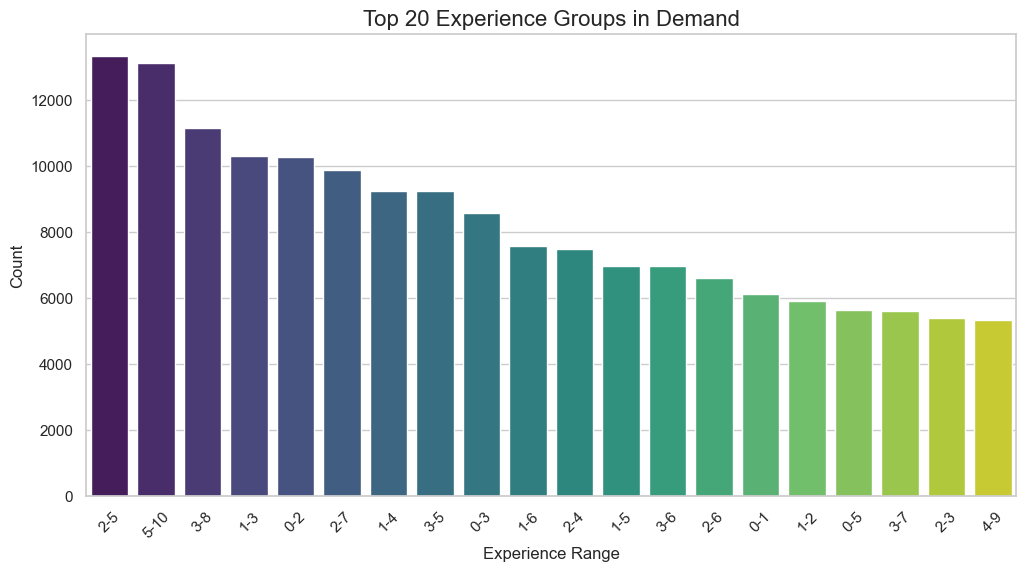

In [181]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_experience_groups.index, y=top_experience_groups.values, palette='viridis')
plt.title('Top 20 Experience Groups in Demand', fontsize=16)
plt.xlabel('Experience Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

**b. Salary Distribution**

In [182]:
print(df_pd['avg_salary'].dtypes)


object


In [183]:
df_pd['avg_salary'] = pd.to_numeric(df_pd['avg_salary'], errors='coerce')
filtered_df = df_pd[df_pd['avg_salary'] > 0.0]
print(df_pd['avg_salary'].dtypes)  

float64


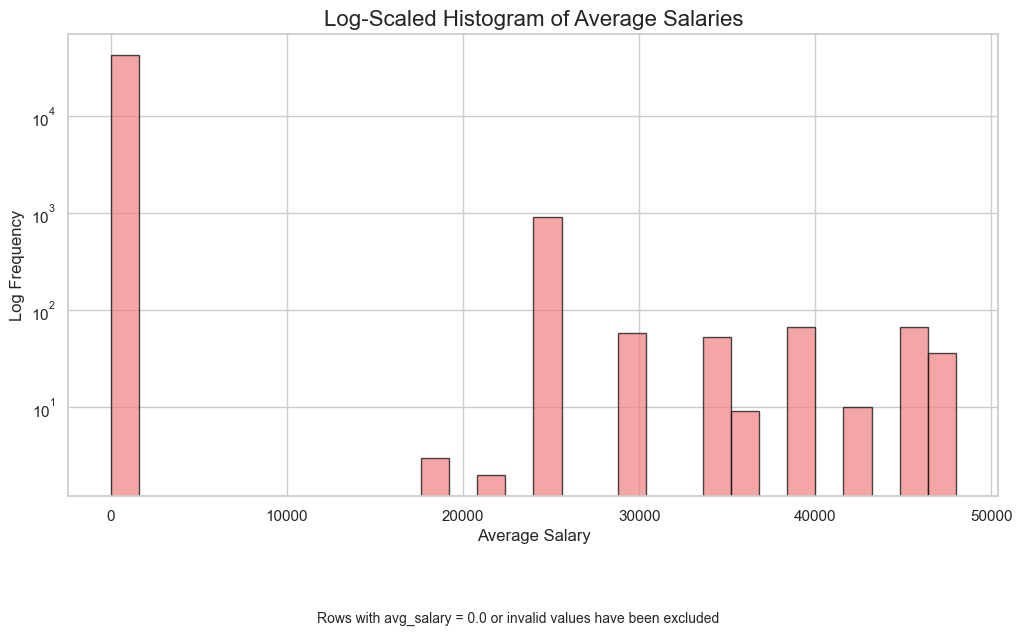

In [184]:
plt.figure(figsize=(12, 6))
plt.hist(filtered_df['avg_salary'], bins=30, log=True, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Log-Scaled Histogram of Average Salaries', fontsize=16)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Log Frequency', fontsize=12)
plt.figtext(0.5, -0.1, 'Rows with avg_salary = 0.0 or invalid values have been excluded', wrap=True, horizontalalignment='center', fontsize=10)
plt.show()


*The graph represents the frequency distribution of average salaries on a logarithmic scale.* 

- **Logarithmic Scale**: Used to emphasize frequency variations across a wide range of salary values, making both low and high occurrences visible.
- **Distribution**: Most average salaries cluster around zero, with additional peaks observed near 20,000, 30,000, 40,000, and 50,000.
- **Insights**: Many rows have average salaries close to zero. Rows with `avg_salary = 0` or invalid values were excluded to focus on meaningful data.

This visualization effectively highlights the distribution trends and reveals underlying data patterns in salary values.


**c. Seniority Level Distribution**

C:\Users\AYUSHI\AppData\Local\Temp\ipykernel_13064\3456170868.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




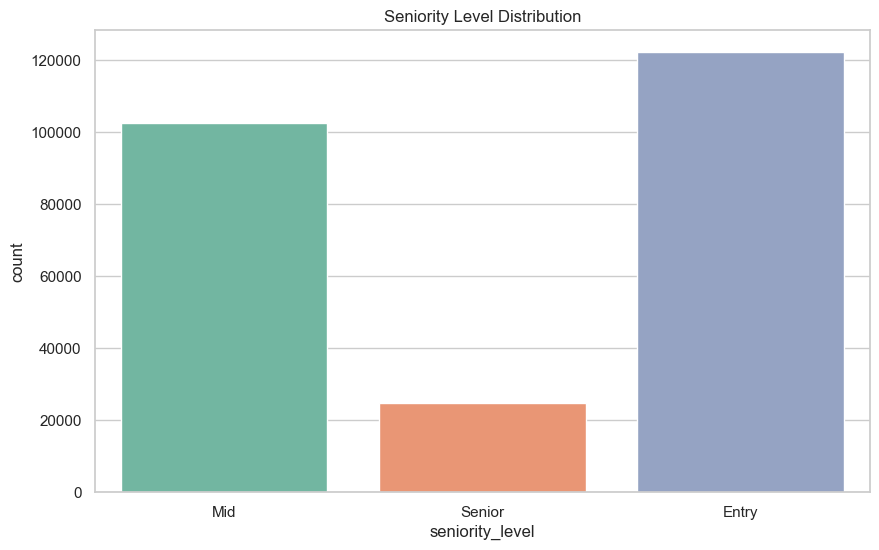

In [185]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_pd, x='seniority_level', palette='Set2')
plt.title('Seniority Level Distribution')
plt.show()


**d.Most Common Job Roles**

C:\Users\AYUSHI\AppData\Local\Temp\ipykernel_13064\3600940652.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




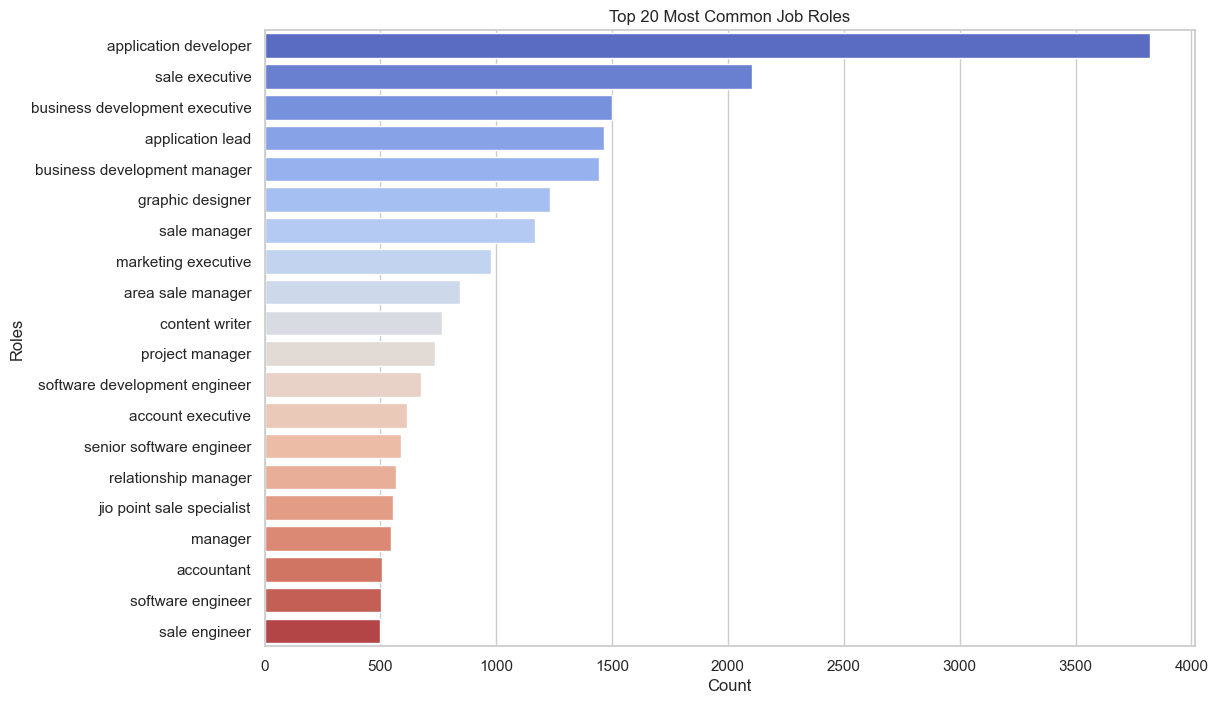

In [186]:
plt.figure(figsize=(12, 8))
roles_count = df_pd['processed_roles'].value_counts().head(20)
sns.barplot(y=roles_count.index, x=roles_count.values, palette="coolwarm")
plt.title("Top 20 Most Common Job Roles")
plt.xlabel("Count")
plt.ylabel("Roles")
plt.show()


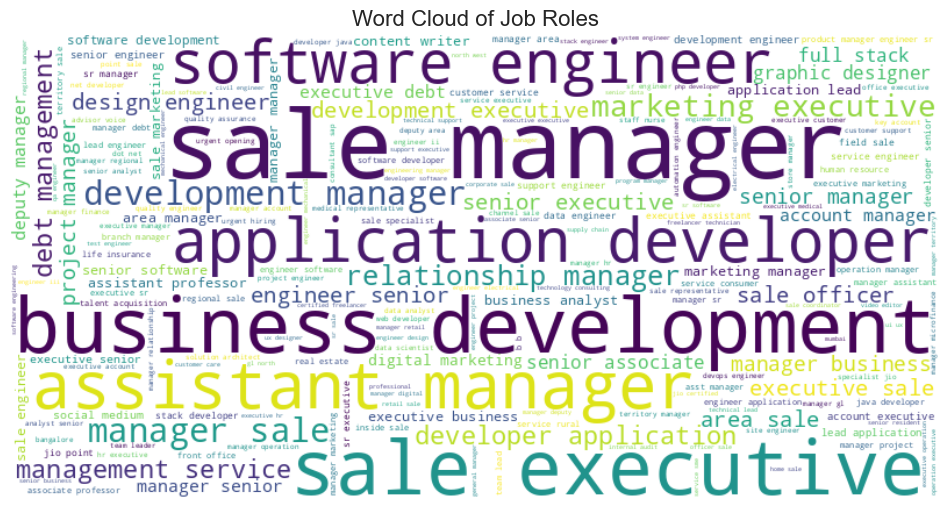

In [187]:
text_roles = ' '.join(df_pd['processed_roles'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text_roles)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Job Roles", fontsize=16)
plt.show()


**e. Most Popular Job Locations**

In [188]:
import plotly.express as px

locations_count = df_pd['processed_location'].value_counts().reset_index()
locations_count.columns = ['Location', 'Count']

fig = px.scatter(locations_count.head(15), x='Location', y='Count', size='Count', color='Location', 
                 title="Top Locations (Bubble Chart)", 
                 size_max=60, template="plotly_dark")
fig.show()


**f.Skills Analysis**

In [189]:
skills_split = [skill.split(', ') for skill in df_pd['extracted_skills'].dropna()]
flat_skills = [item for sublist in skills_split for item in sublist]
skills_count = Counter(flat_skills)

skills_df = pd.DataFrame(skills_count.items(), columns=["Skill", "Count"]).sort_values("Count", ascending=False)

fig = px.sunburst(skills_df.head(20), path=['Skill'], values='Count', 
                  title="Skill Distribution (Sunburst Chart)", color='Count', 
                  color_continuous_scale='blues')
fig.show()


 The chart shows that management-related skills dominate, with project management and business development being the most frequent, followed by sales and customer service skills.


**g.Experience Distribution**

In [190]:
df_pd['min_experience'] = pd.to_numeric(df_pd['min_experience'], errors='coerce')
df_pd['max_experience'] = pd.to_numeric(df_pd['max_experience'], errors='coerce')


<Figure size 1200x800 with 0 Axes>

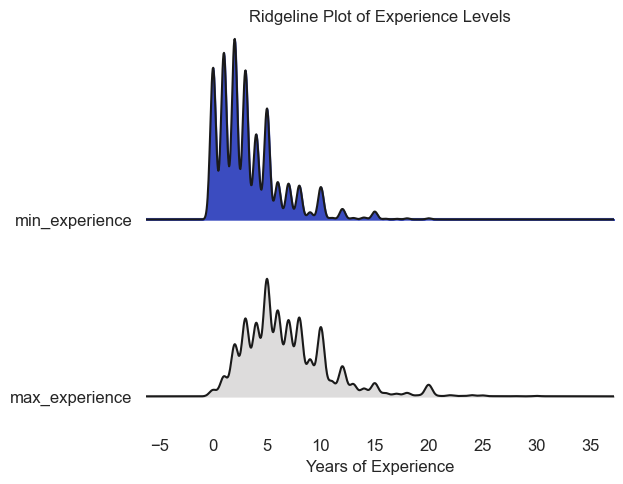

In [191]:
import joypy

plt.figure(figsize=(12, 8))
joypy.joyplot(data=df_pd, column=['min_experience', 'max_experience'], 
              overlap=0.5, colormap=plt.cm.coolwarm, title="Ridgeline Plot of Experience Levels")
plt.xlabel("Years of Experience")
plt.show()


The plot shows that most roles require minimal experience (0 years), while maximum experience levels peak at 5–7 years, with fewer roles requiring over 10 years.


**h.Remote Jobs Analysis**

In [192]:
# Convert to boolean
df_pd['is_remote'] = df_pd['is_remote'].str.lower() == 'true'
 

In [193]:
remote_percentage = df_pd['is_remote'].mean() * 100

In [194]:
import plotly.graph_objects as go

remote_percentage = df_pd['is_remote'].mean() * 100

fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=remote_percentage,
    title={'text': "Percentage of Remote Jobs"},
    gauge={'axis': {'range': [0, 100]},
           'bar': {'color': "blue"},
           'steps': [{'range': [0, 50], 'color': "lightgray"},
                     {'range': [50, 100], 'color': "lightblue"}]}))
fig.show()


The gauge indicates that 50% of the jobs analyzed are remote, reflecting a balanced distribution between remote and non-remote positions.

**i.High Salary Jobs**

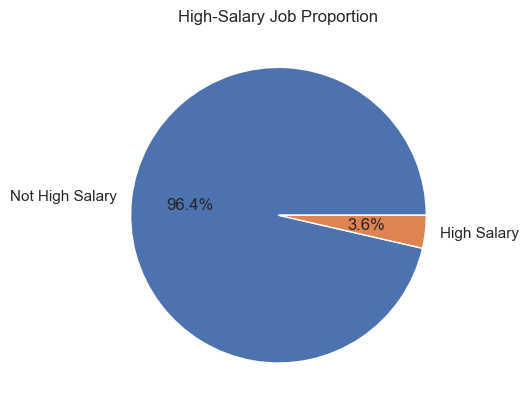

In [195]:
# Count high salary jobs
high_salary_jobs = df_pd['is_high_salary'].value_counts()

# Plot a simple pie chart
plt.pie(high_salary_jobs, labels=["Not High Salary", "High Salary"], autopct='%1.1f%%')
plt.title("High-Salary Job Proportion")
plt.show()

**j.Industry analysis**

In [196]:
industries_count = df_pd['processed_industry'].value_counts().reset_index()
industries_count.columns = ['Industry', 'Count']

fig = px.line_polar(industries_count, r='Count', theta='Industry', 
                    line_close=True, template="plotly_dark", 
                    title="Industries (Radial Chart)")
fig.show()


The radial chart visualizes the distribution of job opportunities across various industries. The analysis reveals that **BFSI (Banking, Financial Services, and Insurance)** and **professional services** dominate the job market with the highest volume of openings. **Infrastructure transport and real estate**, while not at the top, show moderate job availability, indicating steady demand. In contrast, industries like **education** and **medium entertainment telecom** have the lowest job opportunities, highlighting sector-specific disparities in demand.


#### Bivariate Analysis

**Skills vs Roles**

In [197]:
# Group by roles and aggregate skills
role_skills = df_pd.groupby('processed_roles')['extracted_skills'].apply(
    lambda x: ', '.join(x.dropna().astype(str))
).reset_index()

# Count the number of skills associated with each role
role_skills['skill_count'] = role_skills['extracted_skills'].str.split(', ').apply(len)

# Limit to the top 10 roles based on skill count
role_skills = role_skills.nlargest(10, 'skill_count')

# Extract the top 10 skills for each role
role_skills['top_skills'] = role_skills['extracted_skills'].apply(
    lambda x: ', '.join(pd.Series(x.split(', ')).value_counts().head(10).index)
)

# Create bar chart with skill tooltips
fig = px.bar(
    role_skills,
    x='processed_roles',
    y='skill_count',
    title="Top 10 Roles and Their Skill Requirements",
    color='skill_count',
    color_continuous_scale='viridis',
    labels={'processed_roles': 'Roles', 'skill_count': 'Number of Skills'},
    hover_data={'top_skills': True, 'skill_count': True}  # Add skills to tooltip
)

fig.update_traces(hovertemplate=(
    "<b>Role:</b> %{x}<br>" +
    "<b>Skill Count:</b> %{y}<br>" +
    "<b>Top Skills:</b> %{customdata[0]}"
))

fig.show()


"Sale Executive" has the highest skill requirement, nearly 20,000 skills.

"Application Lead" has the lowest skill requirement among the top 10, with around 10,000 skills.

**Locations vs. Salary**

C:\Users\AYUSHI\AppData\Local\Temp\ipykernel_13064\1074377460.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\AYUSHI\AppData\Local\Temp\ipykernel_13064\1074377460.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




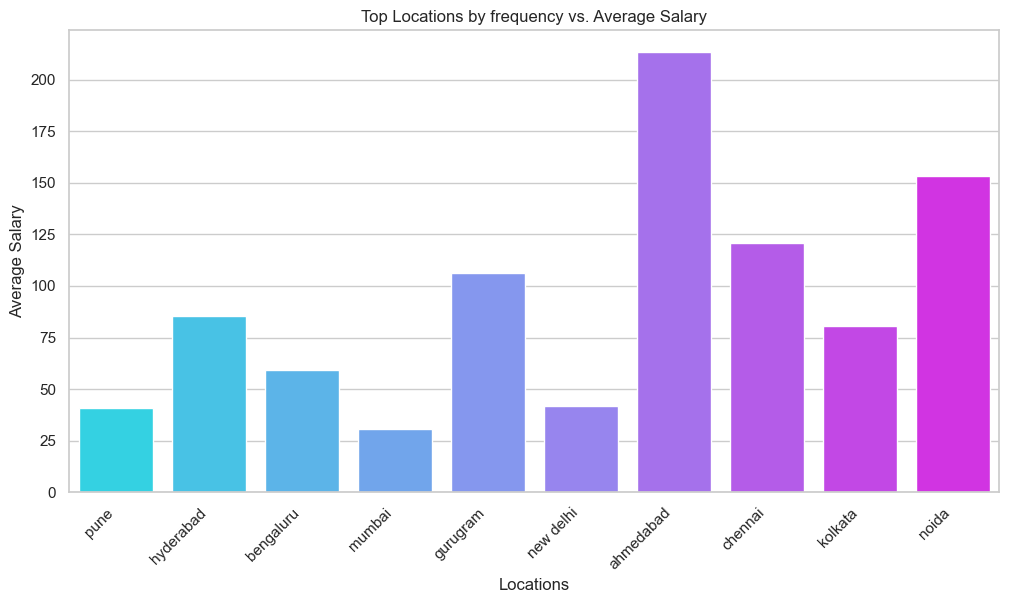

In [198]:
top_locations = df_pd['processed_location'].value_counts().head(10).index
filtered_locations = df_pd[df_pd['processed_location'].isin(top_locations)]

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_locations, x='processed_location', y='avg_salary', ci=None, palette="cool")
plt.xticks(rotation=45, ha="right")
plt.title("Top Locations by frequency vs. Average Salary")
plt.xlabel("Locations")
plt.ylabel("Average Salary")
plt.show()


**Location Vs. Roles**

In [199]:
location_roles = df_pd.groupby(['locations', 'roles']).size().reset_index(name='count')
location_roles = location_roles.nlargest(20, 'count')  # Focus on top 20 combinations

fig = px.sunburst(location_roles, path=['locations', 'roles'], 
                  values='count', 
                  title="Top Locations and Roles Distribution", 
                  color='count', 
                  color_continuous_scale='Blues')
fig.show()


From the graph, it is evident that Bengaluru dominates with the highest count of roles, particularly in application development, followed by Mumbai, Pune, and Hyderabad. Application developers and application leads are the most prevalent roles across these cities.

**Roles Requiring the Most Experience**

In [200]:
# Ensure 'experience_cleaned' is numeric
df_pd['experience_cleaned'] = pd.to_numeric(df_pd['experience_cleaned'], errors='coerce')

# Drop rows with NaN values in 'experience_cleaned'
df_pd = df_pd.dropna(subset=['experience_cleaned'])

# Group by 'roles' and calculate mean experience
experience_roles = df_pd.groupby('roles', as_index=False)['experience_cleaned'].mean()

# Get the top 10 roles requiring the most experience
experience_roles = experience_roles.nlargest(10, 'experience_cleaned')

# Create a bar chart
fig = px.bar(
    experience_roles, 
    x='roles', 
    y='experience_cleaned', 
    title="Roles Requiring the Most Experience", 
    color='experience_cleaned', 
    color_continuous_scale='Turbo'
)

# Customize the layout
fig.update_layout(
    xaxis_title="Roles", 
    yaxis_title="Average Experience (Years)", 
    xaxis_tickangle=45
)
# Display the chart
fig.show()


This chart shows roles like **director** and **senior manager** require the most experience (20+ years), while others like **systems manager** need 14–18 years, reflecting varying demands across roles.

In [201]:
location_salary = df_pd.groupby('processed_location')['avg_salary'].mean().reset_index()
location_salary = location_salary.nlargest(10, 'avg_salary')  # Top 10 high-paying locations

fig = px.scatter(location_salary, x='processed_location', y='avg_salary', 
                 size='avg_salary', color='processed_location', 
                 title="Top High-Paying Locations", 
                 size_max=60)
fig.update_layout(xaxis_title="Locations", yaxis_title="Average Salary", xaxis_tickangle=45)
fig.show()


In [220]:
industry_roles = df_pd.groupby(['processed_industry', 'processed_roles']).size().reset_index(name='role_count')

fig = px.sunburst(industry_roles, 
                  path=['processed_industry', 'processed_roles'], 
                  values='role_count',
                  title="Role Demand Across Industries")
fig.show()


In [221]:
# Ensure salary, experience_cleaned, and job_age_days are in numeric format
df_pd['salary'] = pd.to_numeric(df_pd['salary'], errors='coerce')
df_pd['experience_cleaned'] = pd.to_numeric(df_pd['experience_cleaned'], errors='coerce')
df_pd['job_age_days'] = pd.to_numeric(df_pd['job_age_days'], errors='coerce')

# Grouping by industry to get average salary and experience
industry_summary = df_pd.groupby('processed_industry').agg(
    avg_salary=('salary', 'mean'),
    avg_experience=('experience_cleaned', 'mean'),
    job_count=('processed_roles', 'count')
).reset_index()

# Create a bubble chart to show Industry vs Salary, with bubble size as Experience
fig = px.scatter(industry_summary,
                 x='processed_industry', 
                 y='avg_salary', 
                 size='avg_experience', 
                 color='job_count',
                 hover_name='processed_industry',
                 title="Industry-wise Salary, Experience, and Job Demand",
                 labels={'processed_industry': 'Industry', 'avg_salary': 'Average Salary', 'avg_experience': 'Average Experience Required'},
                 size_max=60, 
                 color_continuous_scale='Viridis')

fig.show()

#### Multivariate Analysis 

C:\Users\AYUSHI\AppData\Local\Temp\ipykernel_13064\381498883.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




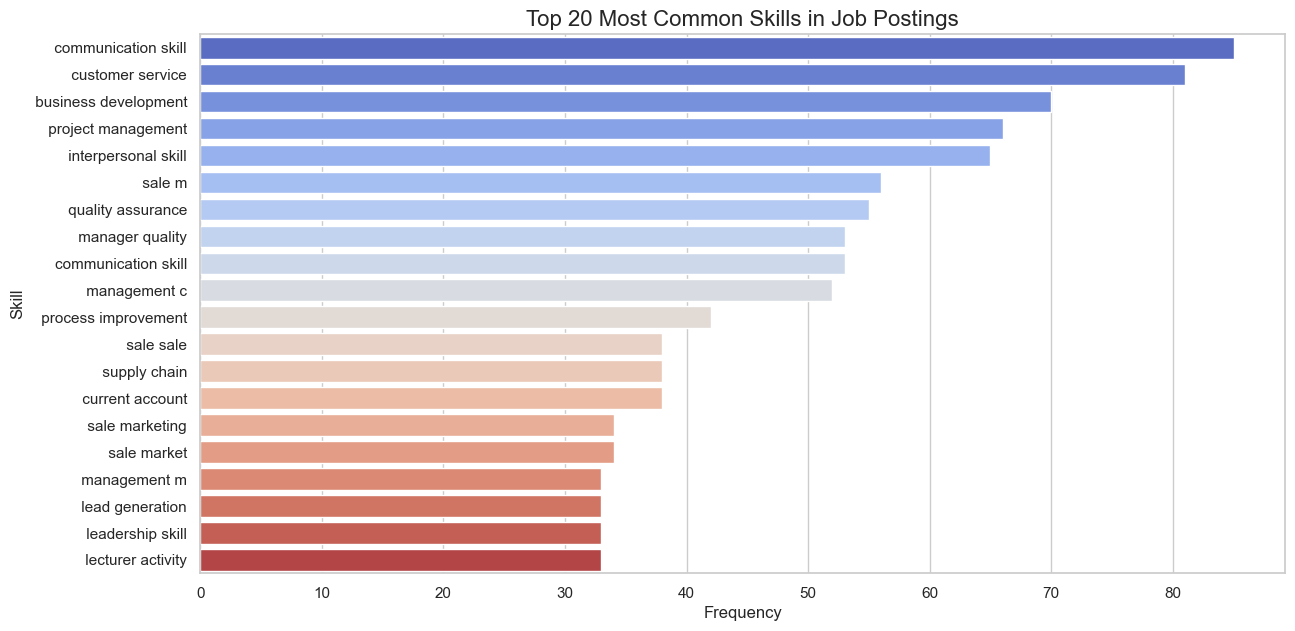

In [202]:
# Extract skills (explode 'extracted_skills' column)
skills = df_pd['extracted_skills'].dropna().str.split(',').explode()

# Count the frequency of each skill
skill_counts = Counter(skills)

# Create a bar plot of the top 20 most frequent skills
top_skills = pd.DataFrame(skill_counts.most_common(20), columns=["Skill", "Frequency"])

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Skill', data=top_skills, palette="coolwarm")
plt.title("Top 20 Most Common Skills in Job Postings", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Skill", fontsize=12)
plt.show()


In [203]:
df_filtered = df_pd.dropna(subset=['experience_cleaned', 'salary', 'processed_location'])

# Create a 3D scatter plot with relevant columns
fig = px.scatter_3d(df_filtered, 
                    x='experience_cleaned', 
                    y='salary', 
                    z='processed_location', 
                    color='processed_roles', 
                    title="3D Scatter Plot: Salary, Experience, Location by Roles",
                    color_continuous_scale=px.colors.sequential.Plasma)

# Update layout for better readability
fig.update_layout(
    scene=dict(
        xaxis_title='Experience (Cleaned)',
        yaxis_title='Salary',
        zaxis_title='Location'
    ),
    coloraxis_colorbar=dict(title="Roles")
)

# Show the plot
fig.show()


**3D Scatter Plot: Salary, Experience, Location by Roles**

The plot visualizes job roles, experience, salary, and location distribution. Each point represents a job entry, colored by the role. From the graph, we can observe a clustering of various job roles in certain experience and salary ranges. Locations are also distributed across the axes, revealing concentration in specific regions. The spread indicates that roles such as "Software Engineer" and "Internship Onboarding Operation" have a wider experience and salary range, while roles like "Apprenticeship Graduate Pas Out" are more concentrated in specific bands. 

**Key Findings:**
- Salary distribution varies significantly across roles.
- Experience correlates with higher salary in many roles.
- Certain locations, like Bengaluru and Hyderabad, show more job diversity.

#### Skills analysis

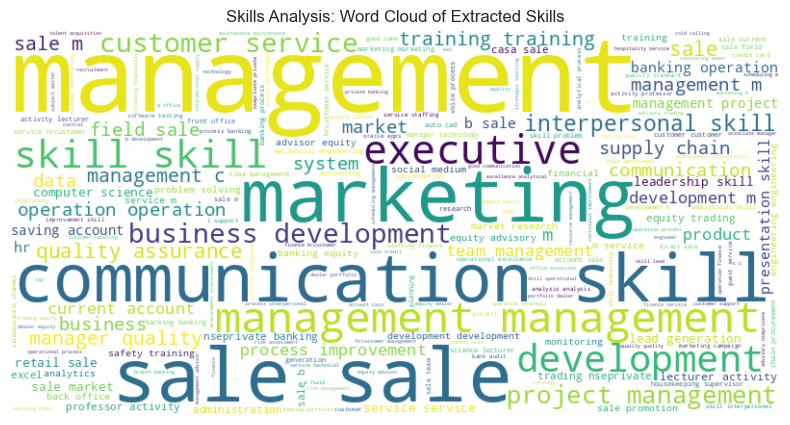

In [204]:
# Combine all skills into one large string
all_skills = ' '.join(df_pd['extracted_skills'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_skills)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Skills Analysis: Word Cloud of Extracted Skills")
plt.show()


**Skills Demand Across Top Roles**

In [205]:
role_counts = df_pd['processed_roles'].value_counts().reset_index()
role_counts.columns = ['processed_roles', 'role_count']

# Step 2: Merge role_counts with the extracted skills (if needed)
roles_skills = pd.merge(df_pd, role_counts, on='processed_roles', how='inner')

# Step 3: Create a list of top 20 roles based on their count
top_20_roles = role_counts.nlargest(20, 'role_count')

# Step 4: Filter the data for top 20 roles
roles_skills_top20 = roles_skills[roles_skills['processed_roles'].isin(top_20_roles['processed_roles'])]

# Step 5: Generate the Sunburst chart
fig = px.sunburst(roles_skills_top20, 
                  path=['processed_roles', 'extracted_skills'], 
                  title="Skills Demand Across Top 20 Roles", 
                  color='role_count',
                  color_continuous_scale=px.colors.sequential.Plasma)

# Show the plot
fig.show()


### Correlation Heatmap: Numeric Features (Salary, Experience, Job Age)

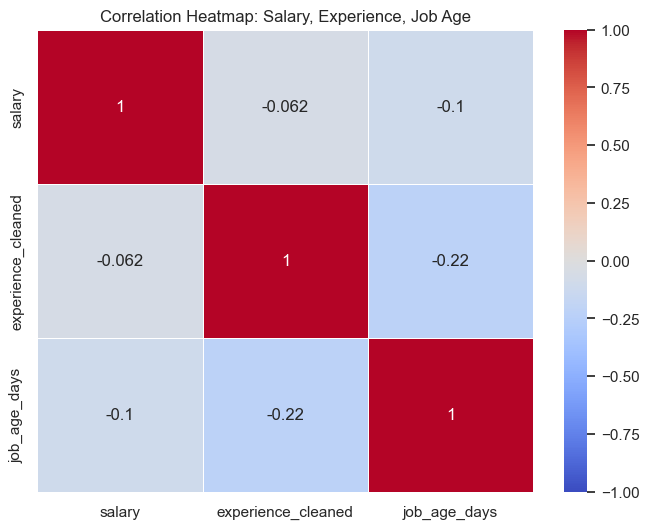

In [212]:
df_pd['salary'] = pd.to_numeric(df_pd['salary'], errors='coerce')

# Convert 'job_age_days' to numeric (coerce errors to NaN if they can't be converted)
df_pd['job_age_days'] = pd.to_numeric(df_pd['job_age_days'], errors='coerce')

# Select numeric columns for correlation analysis
df_numeric = df_pd[['salary', 'experience_cleaned', 'job_age_days']]

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap: Salary, Experience, Job Age")
plt.show()


The color intensity represents the strength of the correlation, with red indicating positive correlation and blue indicating negative correlation. The values within the cells represent the correlation coefficients.

Overall, the heatmap shows that there are weak correlations between the variables. The strongest correlation is between experience_cleaned and job_age_days, but it is still relatively weak.

**Role Demand vs Salary**

In [214]:
role_demand_salary = df_pd.groupby('processed_roles').agg(
    role_demand=('processed_roles', 'count'),
    avg_salary=('salary', 'mean')
).reset_index()

# Create a scatter plot
fig = px.scatter(role_demand_salary, x='role_demand', y='avg_salary', 
                 title="Role Demand vs Salary: Scatter Plot", 
                 color='processed_roles', size='role_demand', 
                 color_discrete_sequence=px.colors.qualitative.Set3)

# Show the plot
fig.update_layout(xaxis_title="Role Demand (Frequency)", yaxis_title="Average Salary")
fig.show()


**Experience vs Salary vs Location**

In [215]:

fig = px.scatter(df_pd, x='experience_cleaned', y='salary', size='experience_cleaned', 
                 color='processed_location', hover_name='processed_roles', 
                 title="Experience vs Salary vs Location (Bubble Chart)", 
                 color_discrete_sequence=px.colors.qualitative.T10)

# Show the plot
fig.update_layout(xaxis_title="Experience", yaxis_title="Salary")
fig.show()


This bubble chart illustrates the relationship between experience, salary, and location. We observe a wide salary range, with salaries generally increasing as experience grows. Location plays a crucial role, with cities like Mumbai and Hyderabad offering higher salary potential, while others like Vellore and Pudukkottai tend to have lower salary ranges. Some locations might have limited data or be excluded due to data quality or filtering criteria.

**These analyses contribute to the optimization of the job application process by providing insights into skills demand, salary expectations, experience levels, and location-based trends. By leveraging these insights, recruiters can adjust their hiring strategies, while job seekers can focus their efforts on roles that match their skills, experience, and salary expectations, leading to a more efficient and effective job application process.**